In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

# Blazhko analysis

---

*Authors: Ema Donev and dr. Ivezić*

In this notebook we tackle the selection of Blazhko candidates via an algorithm we designed, followed by visual analysis of all the candidates with their phase graphs, periodograms, total observation plot and a seasonal plot. We look for signs of amplitude or phase modulation, marks of the Blazhko effect.  

### DATA SETUP

In [4]:
#| code-fold: false
# LINEAR DATA
# ------------
dataL = fetch_LINEAR_sample(data_home='../inputs')

In [5]:
end = 'ffinal'

# DATA from previous notebook
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [6]:
print(lc_analysis.shape)
lc_analysis.head()

(2857, 34)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7952,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5545,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.8840,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4821,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1860,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN


---

In [7]:
blazhko_can = pd.DataFrame(())
blazhko_can, blazhko_can_stat = blazhko_determine(lc_analysis, blazhko_can, 'IndicatorType', 'BE_score')
blazhko_can.to_csv("../outputs/blazhko_can"+end+"_expanded.csv", index=False)
blazhko_can_stat.to_csv('../outputs/blazhko_stats'+end+'_expanded.csv', index=False)

In [8]:
#blazhko_can = pd.read_csv("../outputs/blazhko_can"+end+".csv")
#blazhko_ca_stat = pd.read_csv("../outputs/blazhko_stats"+end+".csv")

print(blazhko_can.shape)
blazhko_can.head(10)

(618, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,5.0,NaN
1,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,5.0,NaN
2,136668,0.532923,0.532929,0.532926,1.000011,310,1.6,1.1,1.7,1.1,...,1.9396,15.8391,0.0132,17.7235,0.04,0.00001,NaN,NaN,5.0,NaN
3,141414,0.335690,0.335669,0.335680,0.999937,278,0.6,0.8,1.2,1.0,...,2.9930,71.8907,0.0057,20.7571,0.04,0.00006,NaN,Z,6.0,period
4,142794,0.470787,0.470802,0.470794,1.000032,270,1.8,1.0,2.1,1.1,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,NaN,NaN,5.0,NaN
5,158779,0.609207,0.609189,0.609198,0.999970,293,3.7,1.6,4.3,1.6,...,1.6444,350.2627,0.0123,16.5371,0.21,0.00003,NaN,NaN,5.0,NaN
6,162255,0.512747,0.512744,0.512745,0.999994,266,5.7,1.6,5.5,1.6,...,1.9765,38.1243,0.0161,27.1254,0.35,0.00001,NaN,NaN,5.0,NaN
7,174389,0.334036,0.334040,0.334038,1.000012,270,4.5,1.4,4.6,1.4,...,2.9968,320.0000,0.0036,20.7813,0.06,0.00001,NaN,NaN,5.0,NaN
8,258499,0.401505,0.401504,0.401505,0.999998,275,2.7,1.5,2.7,1.5,...,2.5182,36.2384,0.0067,16.4915,0.02,0.00000,NaN,Z,8.0,period
9,263541,0.558218,0.558221,0.558220,1.000005,270,15.8,2.9,16.2,3.0,...,1.8025,89.9685,0.0021,7.5968,0.18,0.00001,NaN,NaN,5.0,NaN


In [9]:
print(blazhko_can_stat.shape)
blazhko_can_stat.head(10)

(2857, 6)


,LINEAR chi2,ZTF chi2,LINEAR periodogram,ZTF periodogram,Amplitude,Period difference
0,0,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,1,0,0,0,1
9,0,0,0,0,0,0


In [10]:
grouped = blazhko_can_stat.groupby(['LINEAR chi2', 'ZTF chi2', 'LINEAR periodogram', 'ZTF periodogram', 'Amplitude', 'Period difference']).size().reset_index(name='counts')

In [11]:
grouped

,LINEAR chi2,ZTF chi2,LINEAR periodogram,ZTF periodogram,Amplitude,Period difference,counts
0,0,0,0,0,0,0,2513
1,0,0,0,0,1,0,48
2,0,0,0,0,1,1,1
3,0,0,0,1,0,0,19
4,0,0,1,0,0,0,30
5,0,0,1,1,0,0,1
6,0,1,0,0,0,0,75
7,0,1,0,0,0,1,5
8,0,1,0,0,1,0,80
9,0,1,0,0,1,1,5


<Figure size 1500x1000 with 0 Axes>

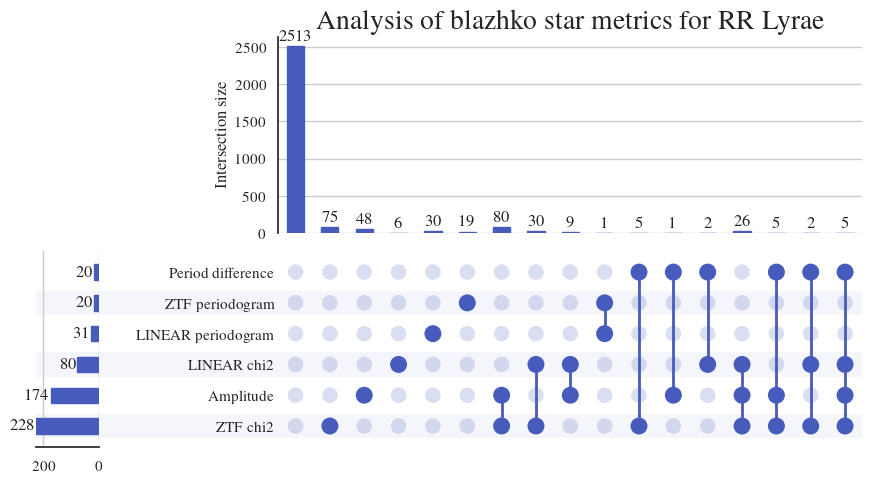

In [12]:
from upsetplot import UpSet
import pandas as pd
import matplotlib.pyplot as plt

# Convert grouped DataFrame to a format for UpSet plot
binary_columns = ['LINEAR chi2', 'ZTF chi2', 'LINEAR periodogram', 'ZTF periodogram', 'Amplitude', 'Period difference']
upset_data = grouped.set_index(binary_columns)['counts']

# Create UpSet plot
plt.figure(figsize=(15, 10))
upset = UpSet(upset_data, subset_size='sum', sort_by='degree', facecolor=b1, other_dots_color=0.2, show_counts=True)
upset.plot()
plt.title("Analysis of blazhko star metrics for RR Lyrae", fontsize=20)
#plt.tick_params(labelsize=28)
plt.savefig('../img_rsc/stats_categories_expanded.png', dpi=500)
plt.show()


# Step 02: Visual analysis

This process was conducted in 4 phases:
1. ### The phased graph
Firstly, the shape and noisiness of the phased light curves were examined. If the light curve had the correct shape, there wasn't too much noise ($\chi^2$ wasn't too high) and there appeared to be smearing of the phased light curve ( a sign of modulation ), the light curve passed the first phase.

2. ### The periodogram
Secondly, the correctness of the algorithm in recognizing the blazhko frequency was looked at. If the blazhko peaks are right next to the yearly alias and not statistically significant, or if the algorithm detected a false signal, the light curve wouldn't pass this phase.

3. ### The full data
Thirdly, the general shape of the light curve was looked at. If the data showed a wave-like pattern, it would indicate the presence of amplitude modulation.

4. ### Seasons of observation
Finally, the most important phase, where we analyzed the light curve fit for each observation season, comparing how the light curve changed depending on the phased and normalized graph. We look for a translation in the x-coordinate, or a *phase modulation*, or if the width of the light curve changes during seasons, we found *amplitude modulation*.

A star can satisfy all 4 criteria, the first and final stage, or just the second stage to be considered a Blazhko star.

---

In [13]:
blazhko_can_orig = pd.read_csv('../outputs/blazhko_canffinal.csv')

In [16]:
# Selecting rows from blazhko_can where 'LINEAR id' is not in blazhko_can_orig['LINEAR id']
be_other = blazhko_can[~blazhko_can['LINEAR id'].isin(blazhko_can_orig['LINEAR id'])]
be_other = be_other.reset_index(drop=True)
print(be_other.shape)
be_other.head()

(379, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,5.0,NaN
1,136668,0.532923,0.532929,0.532926,1.000011,310,1.6,1.1,1.7,1.1,...,1.9396,15.8391,0.0132,17.7235,0.04,0.00001,NaN,NaN,5.0,NaN
2,141414,0.335690,0.335669,0.335680,0.999937,278,0.6,0.8,1.2,1.0,...,2.9930,71.8907,0.0057,20.7571,0.04,0.00006,NaN,Z,6.0,period
3,142794,0.470787,0.470802,0.470794,1.000032,270,1.8,1.0,2.1,1.1,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,NaN,NaN,5.0,NaN
4,162255,0.512747,0.512744,0.512745,0.999994,266,5.7,1.6,5.5,1.6,...,1.9765,38.1243,0.0161,27.1254,0.35,0.00001,NaN,NaN,5.0,NaN


In [18]:
BE_candidates_other = category_analysis(be_other, fits, periodogr, ztf_data, dataL)

This dataset has 379 stars.


In [ ]:
blazhko_analyzerother = BE_candidates_other.get_save_data()
end = 'EXTRA'
blazhko_analyzerother.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerother.shape)

---